# Fantasy Hockey Draft

This notebook will simulate a fantasy hockey draft using Markowitz optimization stradegies, and also supports the possiblity of a human player. 

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import importlib
import sys

sys.path.insert(1, '../')
import scripts.hockey_bots as hockey

# need to keep reloading for development work because 
# I apparently like Jupyter too much 
importlib.reload(hockey)

<module 'scripts.hockey_bots' from '../scripts/hockey_bots.py'>

## Importing Data Created in `Data Wrangling.ipynb`

In [2]:
player_data = pd.read_csv("../data/player_data_for_optim3.csv")
# aggregate all scores into an array for each player
scores = player_data[['player_id', 'points',]].groupby('player_id').agg(lambda x: list(x)).reset_index()
all_points = pd.DataFrame(np.transpose(scores.points.tolist()), columns = scores.player_id)
idx = list(all_points.mean().sort_values(ascending=False).index)

## Finding Indexes
As we're only interested in aggregate inddexes of average player returns, we need to find each players index according to the aggregation, as well s the indexes of the players in each position done below.

In [3]:
# Finding index in an aggregate score for each position
pointies = list(all_points.mean().index)

defence = hockey.position_indexes(pointies,all_points,player_data,idx, "D")
center = hockey.position_indexes(pointies,all_points,player_data,idx, "C")
goalie = hockey.position_indexes(pointies,all_points, player_data,idx,"G")
right_wingers = hockey.position_indexes(pointies, all_points,player_data,idx,"RW")
left_wingers = hockey.position_indexes(pointies, all_points,player_data,idx,"LW")

## Running the Draft

Here we run the actual draft. Noe that `order` defines the order of the draft and automatically reverses after each round. Also note that the teams will be returned in the order that tay appear in the `functions` list in the final result. 

In [56]:
functions = [hockey.optim_player, 
             hockey.optim_player, 
             hockey.optim_player,
             hockey.optim_player, 
            hockey.optim_player, 
            hockey.optim_player, 
            hockey.optim_player,
            hockey.optim_player,
            hockey.greedy_competitor]

greedy_selections = {}
greedy_selections['goalie'] = []
greedy_selections['defence'] = []
greedy_selections['center'] = []
greedy_selections['right_winger'] = []
greedy_selections['left_winger'] = []


order = [8,1,2,3,4,5,0,7,6]

print(len(order), len(functions))

args = dict(scores = all_points, 
            gammaa = [0.01, 0.025, 0.03, 0.027, 0.031, 0.03, 0.03, .03], 
            greedy_selections = greedy_selections,
            df = player_data,
            defence = defence,
            goalie = goalie,
            center = center,
            left_wingers = left_wingers,
            right_wingers = right_wingers,
            selection = ['max', 'rms', 'max', 'rms', 'optim', 'optim', 'optim', 'optim'],
            sub_gamma = [None, None, None, None, .2, .8, .3, .4])
taken = []
all_players, teams = hockey.draft(functions, order, team_size=17, **args)





9 9
Beginning round 0
Beginning round 1
Beginning round 2
Beginning round 3
Beginning round 4
Beginning round 5
Beginning round 6
Beginning round 7
Beginning round 8
Beginning round 9
Beginning round 10
Beginning round 11
Beginning round 12
Beginning round 13
Beginning round 14
Beginning round 15
Beginning round 16
[]
{'goalie': [347, 6], 'defence': [201, 343, 489, 144, 143, 227, 226, 214, 206], 'center': [342, 50, 490, 127, 205], 'right_winger': [], 'left_winger': [202]}


In [85]:
a.groupby('player_id').mean().sort_values(by='points', ascending=False)
a[a.player_id == 8470638]

,Unnamed: 0,game_id,team_id_x,player_id,Salary,firstName,lastName,primaryPosition,points,team_id_y,won,game_num
37335,70219,2018021250,6,8470638,4375000,Patrice,Bergeron,C,2.290000,30,False,80
37336,69195,2018021230,6,8470638,4375000,Patrice,Bergeron,C,4.851176,29,False,79
37337,67447,2018021204,6,8470638,4375000,Patrice,Bergeron,C,-0.240000,13,True,78
37338,68128,2018021219,6,8470638,4375000,Patrice,Bergeron,C,3.741176,6,False,77
37339,65707,2018021172,6,8470638,4375000,Patrice,Bergeron,C,8.032353,14,True,76
...,...,...,...,...,...,...,...,...,...,...,...,...
37396,3093,2018020061,6,8470638,4375000,Patrice,Bergeron,C,11.603529,17,False,4
37397,3092,2018020061,6,8470638,4375000,Patrice,Bergeron,C,11.603529,6,True,3
37398,1641,2018020032,6,8470638,4375000,Patrice,Bergeron,C,22.701176,9,False,2
37399,1640,2018020032,6,8470638,4375000,Patrice,Bergeron,C,22.701176,6,True,1


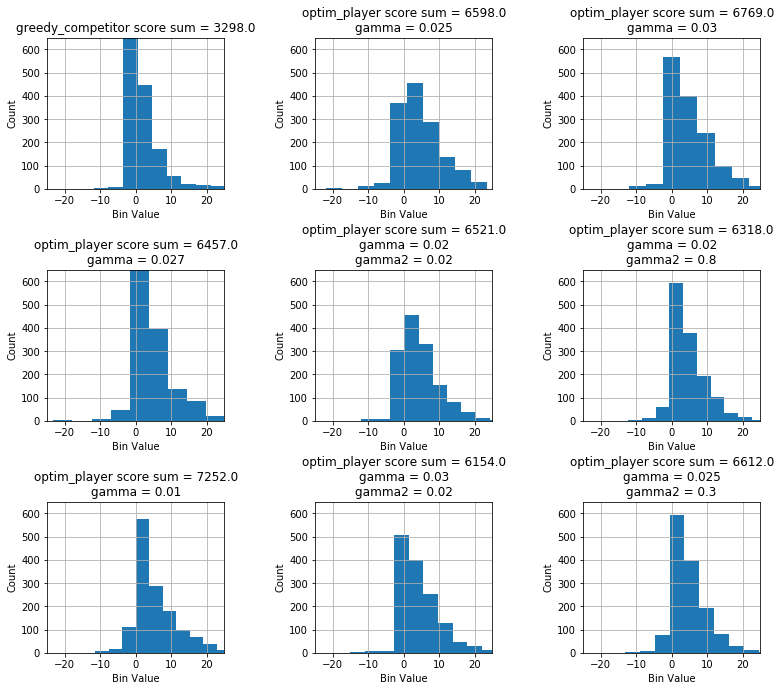

In [128]:
import matplotlib.pyplot as plt
test2 = pd.read_csv("../data/player_data_for_optim2.csv")
a = pd.read_csv("../data/texta.csv")
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(12, 10.5)
fig.tight_layout(pad =6)
cols = []
for i in range(len(teams)):
    ohboy = player_data[player_data.player_id.isin(list(all_points.iloc[:,teams[order[i]]]))]
    playerids = ohboy.groupby('player_id').count().index

    lineup= player_data[player_data.player_id.isin(playerids)].groupby(['firstName', 'lastName', 'primaryPosition']).mean()
    #print(lineup['points'].sum())
    
#     print(a[a.player_id.isin(playerids)]['points'].mean(),
#           a[a.player_id.isin(playerids)]['points'].var())
    sum_score = player_data[player_data.player_id.isin(playerids)]['points'].sum()
    variance_score = player_data[player_data.player_id.isin(playerids)]['points'].std()
    player_data[player_data.player_id.isin(playerids)]['points'].hist(ax=ax[i//3, i%3])
    title = functions[order[i]].__name__ + " score sum = " + str(round(sum_score,0))
    gs = [0.01, 0.025, 0.03, 0.027, 0.02, 0.02, 0.025, .03, None]
    gs2 = [None, None, None, None, .02, .8, .3, .02, None]
    if functions[order[i]].__name__ == 'optim_player':
        title += "\ngamma = " + str(gs[order[i]]) 
        if gs2[order[i]]:
            title += "\ngamma2 = " + str(gs2[order[i]])
    cols.append(title)
    ax[i//3, i%3].set_title(title)
    ax[i//3, i%3].set_ylim([0,650])
    ax[i//3, i%3].set_xlim([-25,25])
    ax[i//3, i%3].set_ylabel("Count")
    ax[i//3, i%3].set_xlabel("Bin Value")
    
    
                           
    # lineup

In [68]:
cols

['greedy_competitor score sum = 2449.0',
 'optim_player score sum = 3610.0\ngamma = 0.025',
 'optim_player score sum = 5082.0\ngamma = 0.03',
 'optim_player score sum = 4204.0\ngamma = 0.027',
 'optim_player score sum = 5478.0\ngamma = 0.02\ngamma2 = 0.02',
 'optim_player score sum = 5612.0\ngamma = 0.02\ngamma2 = 0.8',
 'optim_player score sum = 4442.0\ngamma = 0.01',
 'optim_player score sum = 5129.0\ngamma = 0.03\ngamma2 = 0.02',
 'optim_player score sum = 5569.0\ngamma = 0.025\ngamma2 = 0.3']

In [132]:
teams_df = pd.DataFrame(columns = cols)

for i in range(len(teams)):
    ohboy = player_data[player_data.player_id.isin(list(all_points.iloc[:,teams[order[i]]]))]
    playerids = ohboy.groupby('player_id').count().index
    ttt = player_data[player_data.player_id.isin(playerids)][['firstName', 'lastName', 'primaryPosition']].groupby(["lastName", 'firstName']).max().reset_index()
    ttt['name'] = ttt['firstName'] + " " + ttt['lastName'] + " pos: " + ttt['primaryPosition']
    ttt = ttt.groupby("name").max().reset_index()
    teams_df[cols[i]] = ttt['name'].copy()

teams_df

,greedy_competitor score sum = 3298.0,optim_player score sum = 6598.0\ngamma = 0.025,optim_player score sum = 6769.0\ngamma = 0.03,optim_player score sum = 6457.0\ngamma = 0.027,optim_player score sum = 6521.0\ngamma = 0.02\ngamma2 = 0.02,optim_player score sum = 6318.0\ngamma = 0.02\ngamma2 = 0.8,optim_player score sum = 7252.0\ngamma = 0.01,optim_player score sum = 6154.0\ngamma = 0.03\ngamma2 = 0.02,optim_player score sum = 6612.0\ngamma = 0.025\ngamma2 = 0.3
0,Andrei Vasilevskiy pos: G,Braden Holtby pos: G,Anders Lee pos: LW,Anton Khudobin pos: G,Aleksander Barkov pos: C,Alex Ovechkin pos: LW,Alex Pietrangelo pos: D,Aaron Ekblad pos: D,Anders Nilsson pos: G
1,Casey Cizikas pos: C,Carey Price pos: G,Brad Marchand pos: LW,Bo Horvat pos: C,Alexandar Georgiev pos: G,Alexander Radulov pos: RW,Artemi Panarin pos: LW,Alex DeBrincat pos: RW,Andreas Athanasiou pos: LW
2,Cody Ceci pos: D,Carter Hutton pos: G,Brayden Point pos: C,Brendan Gallagher pos: RW,Connor McDavid pos: C,Colton Parayko pos: D,Auston Matthews pos: C,Cam Atkinson pos: RW,Blake Wheeler pos: RW
3,Colin White pos: C,Connor Hellebuyck pos: G,Claude Giroux pos: C,Brock Nelson pos: C,Evgeny Kuznetsov pos: C,Dylan Larkin pos: C,Ben Bishop pos: G,Darnell Nurse pos: D,Brent Burns pos: D
4,David Krejci pos: C,Damon Severson pos: D,Curtis McElhinney pos: G,Devan Dubnyk pos: G,Filip Forsberg pos: LW,Jake Allen pos: G,Darcy Kuemper pos: G,Erik Karlsson pos: D,David Rittich pos: G
5,David Savard pos: D,Dougie Hamilton pos: D,Elias Pettersson pos: C,Jason Zucker pos: LW,Jeff Petry pos: D,Jake Guentzel pos: C,David Pastrnak pos: RW,Jack Eichel pos: C,Esa Lindell pos: D
6,Henrik Lundqvist pos: G,Elias Lindholm pos: C,Gustav Nyquist pos: RW,John Gibson pos: G,Kyle Connor pos: LW,Joe Pavelski pos: C,Erik Gustafsson pos: D,Jakub Vrana pos: LW,Keith Yandle pos: D
7,Jake Gardiner pos: D,Jacob Markstrom pos: G,Jacob Trouba pos: D,Jonathan Huberdeau pos: LW,Mathew Barzal pos: C,John Carlson pos: D,Frederik Andersen pos: G,Johnny Gaudreau pos: LW,Max Domi pos: LW
8,Jonas Siegenthaler pos: D,Jamie Benn pos: LW,Jake Muzzin pos: D,Mark Scheifele pos: C,Matt Duchene pos: C,Jonathan Toews pos: C,Gabriel Landeskog pos: LW,Jonathan Marchessault pos: C,Mike Hoffman pos: LW
9,Justin Holl pos: D,Jeff Skinner pos: LW,Leon Draisaitl pos: C,Matt Niskanen pos: D,Nikita Kucherov pos: RW,Josh Bailey pos: RW,Jaroslav Halak pos: G,Josh Anderson pos: RW,Nathan MacKinnon pos: C


In [126]:
ohboy = test2[test2.player_id.isin(list(all_points.iloc[:,teams[order[1]]]))]
playerids = ohboy.groupby('player_id').count().index
a[a.player_id.isin(playerids)][['firstName', 'lastName', 'primaryPosition']].groupby(['firstName', 'lastName','primaryPosition']).max()

player_data[player_data.player_id == 8471724]

,Unnamed: 0,game_id,team_id_x,player_id,Salary,firstName,lastName,primaryPosition,points,team_id_y,won,game_num
34294,34294,2.018021e+09,5.0,8471724,7250000,Kris,Letang,D,1.380000,3.0,1.0,81
34295,34295,2.018021e+09,5.0,8471724,7250000,Kris,Letang,D,3.390000,5.0,1.0,80
34296,34296,2.018021e+09,5.0,8471724,7250000,Kris,Letang,D,4.551176,5.0,1.0,75
34297,34297,2.018021e+09,5.0,8471724,7250000,Kris,Letang,D,5.461176,5.0,1.0,74
34298,34298,2.018021e+09,5.0,8471724,7250000,Kris,Letang,D,3.860000,5.0,0.0,73
...,...,...,...,...,...,...,...,...,...,...,...,...
47280,47280,0.000000e+00,0.0,8471724,7250000,Kris,Letang,D,0.000000,0.0,0.0,77
47281,47281,0.000000e+00,0.0,8471724,7250000,Kris,Letang,D,0.000000,0.0,0.0,78
47282,47282,0.000000e+00,0.0,8471724,7250000,Kris,Letang,D,0.000000,0.0,0.0,79
47283,47283,0.000000e+00,0.0,8471724,7250000,Kris,Letang,D,0.000000,0.0,0.0,62


In [ ]:
### import matplotlib.pyplot as plt
gamm = np.linspace(0, .07, 20)
ret = []
risk = []
for gams in gamm:
    print(gams)
    p,risky,returny = hockey.optim_player(all_points,
                        [], [], .05, 
                        player_data, defence, goalie, center, 
                        right_wingers, left_wingers, full_team=True)
    ret.append(returny)
    risk.append(risky)
    break
    
ohboy = test2[test2.player_id.isin(list(all_points.iloc[:,p]))]
playerids = ohboy.groupby('player_id').count().index

lineup= a[a.player_id.isin(playerids)].groupby(['firstName', 'lastName', 'primaryPosition']).sum()
print(lineup['points'].sum())
lineup
    


In [ ]:
a[a.primaryPosition == 'G'].groupby(['firstName', 'lastName']).mean().sort_values(by='points', ascending=False)

In [ ]:
plt.plot(np.array(ret)/np.array(risk), gamm)